Learning rate = 0.01
epoch 15
Optimizer = Adam
Model - Inceptionv3
images - rgb with normalization
three layes added at top - dense(1000), dropout, dense

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import PIL
import os

import matplotlib.pylab as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_dir = pathlib.Path("./final_dataset/")
data_dir

PosixPath('final_dataset')

# Preprocessing

## Read image files

In [3]:
from matplotlib import path
data_images_dict = {
    'Mask': list(data_dir.glob('**/mask/*')),
    'Improper Mask': list(data_dir.glob('**/improper_mask/*')),
    'Non Mask': list(data_dir.glob('**/no_mask/*'))
}

In [4]:
data_labels_dict = {
    'Mask': 0,
    'Improper Mask': 1,
    'Non Mask': 2
}

## Image to CSV

In [5]:
X, y = [], []

for image_name, images in data_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(data_labels_dict[image_name])

In [6]:
X = np.array(X)
y = np.array(y)

# Visualization

# Model training

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [9]:
IMAGE_SHAPE=(224,224)

In [10]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

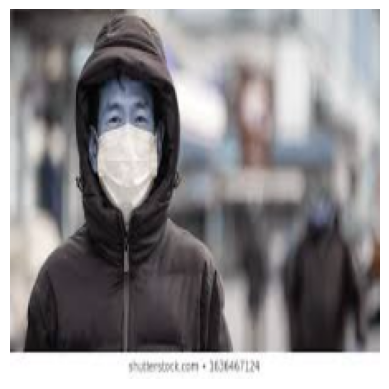

In [11]:
plt.axis('off')
plt.imshow(X[500])

In [12]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3
pretrained_model_without_top_layer = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet',
    input_tensor=None, pooling="avg")

In [13]:
for layers in pretrained_model_without_top_layer.layers:
  layers.trainable = False

In [14]:
num_of_classes = 3

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(1000),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 batch_normalization_94 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 batch_normalization_95 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0

In [15]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [16]:
weight_dir = "weights/50_epoch_inceptionv3"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [17]:
# history = model.fit(X_train_scaled, y_train, epochs=15,initial_epoch=11,callbacks=[checkpoint])
history = model.fit(X_train_scaled, y_train, epochs=50,callbacks=[checkpoint],validation_split=0.20,batch_size=10)

2022-12-07 09:11:19.347266: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50
573/573 [==============================] - 177s 299ms/step - loss: 0.2948 - acc: 0.9300 - val_loss: 0.2209 - val_acc: 0.9302
Epoch 2/50
573/573 [==============================] - 184s 321ms/step - loss: 0.1373 - acc: 0.9534 - val_loss: 0.0991 - val_acc: 0.9637
Epoch 3/50
573/573 [==============================] - 189s 330ms/step - loss: 0.1132 - acc: 0.9632 - val_loss: 0.0684 - val_acc: 0.9777
Epoch 4/50
573/573 [==============================] - 195s 341ms/step - loss: 0.1055 - acc: 0.9656 - val_loss: 0.1256 - val_acc: 0.9644
Epoch 5/50
573/573 [==============================] - 193s 336ms/step - loss: 0.1071 - acc: 0.9632 - val_loss: 0.1287 - val_acc: 0.9644
Epoch 6/50
573/573 [==============================] - 207s 362ms/step - loss: 0.1009 - acc: 0.9675 - val_loss: 0.0767 - val_acc: 0.9797
Epoch 7/50
573/573 [==============================] - 243s 424ms/step - loss: 0.0943 - acc: 0.9661 - val_loss: 0.0761 - val_acc: 0.9825
Epoch 8/50
573/573 [============================

In [18]:
model.evaluate(X_test_scaled,y_test)

56/56 [==============================] - 54s 965ms/step - loss: 0.0734 - acc: 0.9821


[0.07336793839931488, 0.9821228981018066]

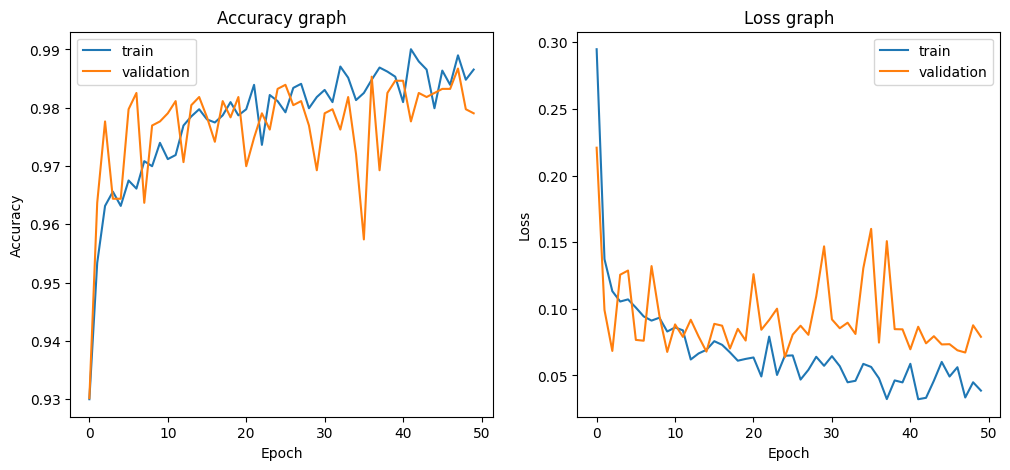

In [19]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('Accuracy graph')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['train','validation'])

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Loss graph')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['train','validation'])

plt.show()

In [20]:
# mask_model =  tf.keras.models.load_model("weights/2805_1/checkpoint-15.hdf5")

In [21]:
model.predict(X_test_scaled[0].reshape(1,224,224,3))

1/1 [==============================] - 1s 797ms/step


array([[ -3.4782634, -14.267399 ,  13.3852215]], dtype=float32)

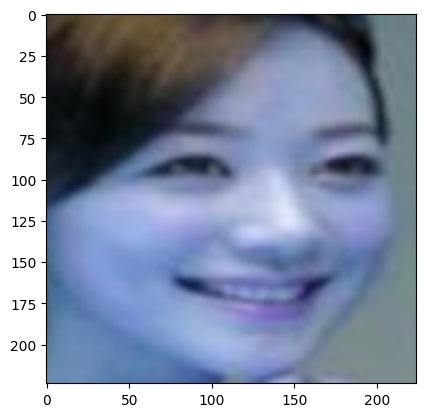

In [22]:
plt.imshow(X_test[0])

In [23]:
y_test[0]

2

In [24]:
import pandas as pd
h = pd.DataFrame(history.history)
h.to_csv("Inception_50_epoch.csv")

AttributeError: module 'pandas' has no attribute 'DataFram'